In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import landfire
import matplotlib.pyplot as plt

C:\Users\rmonaghan\AppData\Local\Temp\ipykernel_14804\34933442.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
c:\U

In [8]:
bbox_gd = gpd.read_file("F:/ESimonson_Workspace/_Projects/RCW_HomeRange/AOI/RedHils_Region.shp")
bbox_gd.plot()

<Axes: >

In [9]:
bbox = bbox_gd['geometry'].bounds
print(bbox)

       minx       miny       maxx       maxy
0 -84.46308  30.247941 -83.531894  30.988274


In [10]:
# Red Hills not covered by LF 2022
lf = landfire.Landfire(bbox="-84.46308 30.24794 -83.531894 30.988274")
lf.request_data(layers=["200CBH_20",  # canopy base height 2020
                        "200CH_20",   # canopy height 2020
                        "200CC_20",   # canopy cover 2020
                        "220EVT",     # existing vegetation type 2020
                        "200NVC"],    # nat'l vegetation classification
                output_path="./LF_dl.zip")

Submitting job...                                  
Job submitted! Processing layers... ⏱️             
Checking status of job again in 5 seconds... 💤    
Most recent message is `US_200CC_20`               
Checking status of job again in 10 seconds... 💤   
Most recent message is `Start creating geotif`     
Checking status of job again in 15 seconds... 💤   
Most recent message is `Start creating geotif`     
Checking status of job again in 20 seconds... 💤   
Job complete! Getting path to .zip file... 🙏      
Data written successfully to ./LF_dl.zip! 🎉       
Job Status: 100%|██████████ [Total Duration: 00:56]


In [2]:
raster_path = "F:/RMonaghan_Workspace/Projects_Main/RCW_HomeRange/Data/LandFire/LF_dl/j6ccc08598d3b4d538db35f300f66ed80.tif"
ds = rioxr.open_rasterio(raster_path)
print(ds.rio.crs)
ds

PROJCS["North_American_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",30.618107],PARAMETER["longitude_of_center",-83.997487],PARAMETER["standard_parallel_1",30.24794],PARAMETER["standard_parallel_2",30.988274],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<xarray.DataArray (band: 5, y: 2741, x: 2989)>
[40964245 values with dtype=int16]
Coordinates:
  * band         (band) int32 1 2 3 4 5
  * x            (x) float64 -4.482e+04 -4.479e+04 ... 4.479e+04 4.482e+04
  * y            (y) float64 4.117e+04 4.114e+04 ... -4.1e+04 -4.103e+04
    spatial_ref  int32 0
Attributes: (12/15)
    AREA_OR_POINT:           Area
    Creator:                 USGS EROS Landfire Product Service
    DataType:                Thematic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1690.56251246344,2228.331054789702,696.514134942...
    STATISTICS_MAXIMUM:      100
    ...                      ...
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       41.116450630659
    _FillValue:              -9999
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               ('US_200CBH_20', 'US_200CH_20', 'US_200CC_20', '...

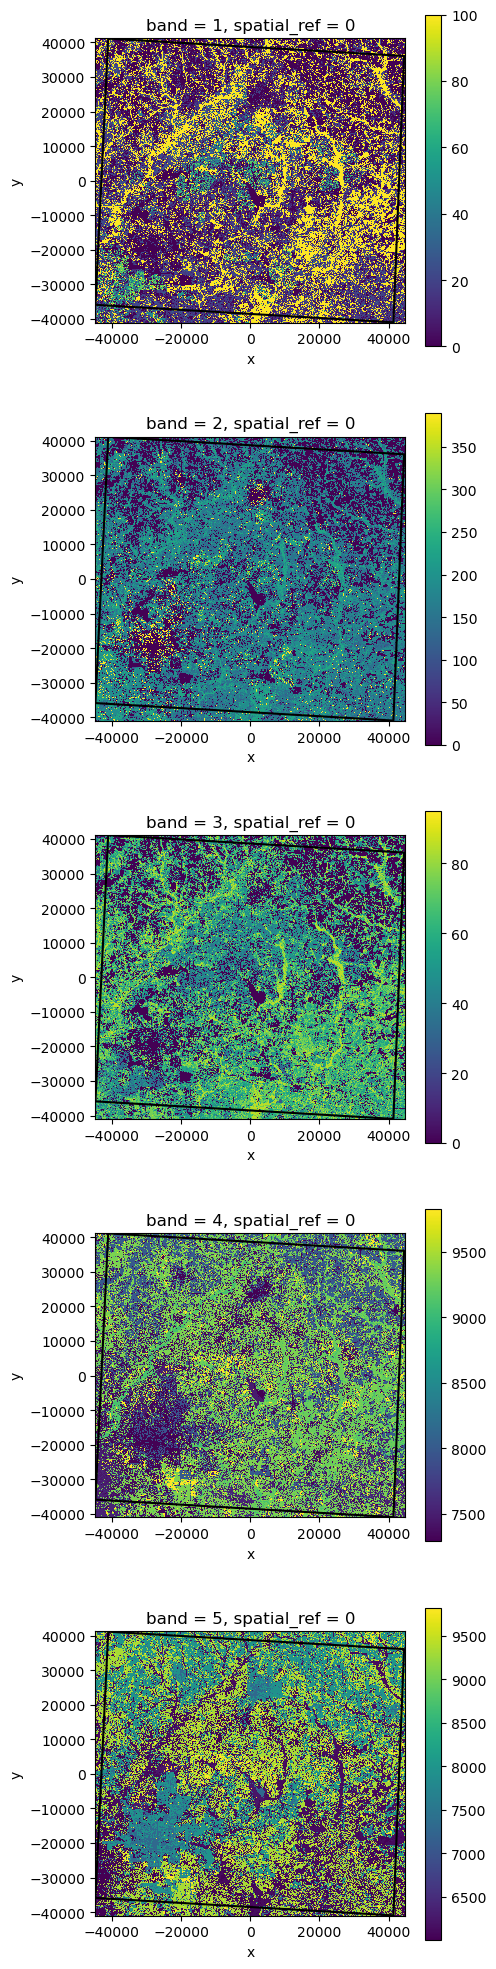

In [12]:
bbox_proj = bbox_gd.to_crs(ds.rio.crs)

fig, ax = plt.subplots(5, 1, figsize=(5,25))
for i in ds.band:
    # print(i.values - 1)
    try:
        x = ds.sel(band=i).plot(ax=ax[i.values - 1], add_colorbar=False)
        bbox_proj.boundary.plot(color='black', ax=ax[i.values - 1])
        cbar = fig.colorbar(x)
        cbar.set_label(ds.attrs['long_name'][i-1])
    except:
        pass

In [9]:
outdir = "F:/RMonaghan_Workspace/Projects_Main/RCW_HomeRange/Data/LandFire/Individual_tifs/"

outname = ['Canopy_Base_Height_2020', 'Canopy_Height_2020', 'Canopy_Cover_2020', 'Existing_Vegetation_Type_2020', 'Natl_Vegetation_Classification']

long_names = ds.attrs['long_name']

for i, ln, name in zip(range(1, len(ds) + 1, 1), long_names, outname):
    sub = ds[ds['band'] == i]
    sub.attrs['long_name'] = ln
    sub.rio.to_raster(outdir + name + '.tif')
